# Nutcracker: Weight Decay vs True Fimbulwinter

**Question:** Does weight decay prevent dead tokens from fully freezing?

In Goldilocks 05, we saw dead tokens reach ~95% frozen but never 100%. Hypothesis: weight decay creates a low-magnitude equilibrium where the inward pressure (toward origin) balances residual gradient signal.

**Experiment:** Train for 6,000 steps with and without weight decay. Track frozen fraction. If the hypothesis is correct:
- **With decay:** Plateaus below 100%
- **Without decay:** Reaches 100% (true fimbulwinter)

## Parameters

In [1]:
# === GOLDILOCKS REFERENCE PARAMETERS ===

import torch

# Paths — reference Goldilocks data
GOLDILOCKS_DATA = "../Goldilocks/data"
TOKENIZER_PATH = f"{GOLDILOCKS_DATA}/tokenizer.json"
TOKENS_PATH = f"{GOLDILOCKS_DATA}/model_corpus_tokens.safetensors"
CENSUS_PATH = f"{GOLDILOCKS_DATA}/token_census.json"

# Architecture: Rich
N_LAYERS = 4
D_MODEL = 128
N_HEADS = 2
D_FF = 256
SEQ_LEN = 128
DROPOUT = 0.0

# Training
BATCH_SIZE = 8
LEARNING_RATE = 1e-3
MODEL_DTYPE = torch.bfloat16
TRAINING_STEPS = 6000

# Experiment: compare these two weight decay values
WEIGHT_DECAY_VALUES = [0.01, 0.0]  # With decay, without decay

# Frozen threshold (same as Goldilocks 05)
FROZEN_THRESHOLD = 1e-4

# Reproducibility
RANDOM_SEED = 42

## Imports & Device

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from safetensors.torch import load_file
from tokenizers import Tokenizer
from pathlib import Path
import json
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

torch.manual_seed(RANDOM_SEED)

# Device detection
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Device: {device}")
print(f"Dtype: {MODEL_DTYPE}")

Device: mps
Dtype: torch.bfloat16


## Load Data

In [3]:
# Load tokenizer
tokenizer = Tokenizer.from_file(TOKENIZER_PATH)
vocab_size = tokenizer.get_vocab_size()
print(f"✓ Tokenizer: {vocab_size:,} tokens")

# Load cached tokenized corpus (fast!)
tokens_data = load_file(TOKENS_PATH)
all_tokens = tokens_data["tokens"].to(torch.long)
print(f"✓ Corpus: {len(all_tokens):,} tokens")

# Load dead token census
with open(CENSUS_PATH, 'r') as f:
    census = json.load(f)
dead_token_ids = set(census['dead_token_ids'])
print(f"✓ Dead tokens: {len(dead_token_ids):,}")

✓ Tokenizer: 3,988 tokens
✓ Corpus: 34,993,926 tokens
✓ Dead tokens: 1,914


## Dataset & Model

In [4]:
class TokenDataset(Dataset):
    """Random chunks from the tokenized corpus."""
    
    def __init__(self, tokens, seq_len, num_samples=100_000):
        self.tokens = tokens
        self.seq_len = seq_len
        self.num_samples = num_samples
        max_start = len(tokens) - seq_len - 1
        self.starts = torch.randint(0, max_start, (num_samples,))
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        start = self.starts[idx]
        chunk = self.tokens[start:start + self.seq_len + 1]
        return chunk[:-1], chunk[1:]


class GPT(nn.Module):
    """Minimal GPT — the Goldilocks reference architecture."""
    
    def __init__(self, vocab_size, d_model, n_heads, n_layers, d_ff, seq_len, dropout=0.0):
        super().__init__()
        self.tok_emb = nn.Embedding(vocab_size, d_model)
        self.pos_emb = nn.Embedding(seq_len, d_model)
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
                dropout=dropout, activation='gelu', batch_first=True, norm_first=True
            ) for _ in range(n_layers)
        ])
        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)
        self.head.weight = self.tok_emb.weight
        self.seq_len = seq_len
        self.register_buffer('causal_mask', None)
    
    def forward(self, x):
        B, T = x.shape
        if self.causal_mask is None or self.causal_mask.shape[0] != T:
            self.causal_mask = torch.triu(
                torch.ones(T, T, device=x.device, dtype=torch.bool), diagonal=1
            )
        pos = torch.arange(T, device=x.device)
        h = self.tok_emb(x) + self.pos_emb(pos)
        for layer in self.layers:
            h = layer(h, src_mask=self.causal_mask, is_causal=True)
        return self.head(self.ln_f(h))


dataset = TokenDataset(all_tokens, SEQ_LEN)
print(f"✓ Dataset: {len(dataset):,} samples")

✓ Dataset: 100,000 samples


## Training Function

In [5]:
def get_dead_embeddings(model, dead_ids):
    """Extract embeddings for dead tokens."""
    W = model.tok_emb.weight.detach()
    dead_ids_tensor = torch.tensor(list(dead_ids), device=W.device)
    return W[dead_ids_tensor].clone()


def train_with_weight_decay(weight_decay, training_steps, desc):
    """Train model and track frozen fraction over time."""
    
    # Fresh model each run
    torch.manual_seed(RANDOM_SEED)
    model = GPT(
        vocab_size=vocab_size,
        d_model=D_MODEL,
        n_heads=N_HEADS,
        n_layers=N_LAYERS,
        d_ff=D_FF,
        seq_len=SEQ_LEN,
        dropout=DROPOUT
    ).to(device).to(MODEL_DTYPE)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=weight_decay)
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    loader_iter = iter(loader)
    
    # Tracking
    history = {'step': [], 'frozen_frac': [], 'loss': []}
    
    W_dead_prev = get_dead_embeddings(model, dead_token_ids)
    model.train()
    
    pbar = tqdm(range(training_steps), desc=desc)
    for step in pbar:
        try:
            x, y = next(loader_iter)
        except StopIteration:
            loader_iter = iter(loader)
            x, y = next(loader_iter)
        
        x, y = x.to(device), y.to(device)
        
        optimizer.zero_grad()
        logits = model(x)
        loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()
        optimizer.step()
        
        # Track frozen fraction
        W_dead_curr = get_dead_embeddings(model, dead_token_ids)
        displacements = W_dead_curr - W_dead_prev
        magnitudes = torch.norm(displacements, dim=1).float().cpu().numpy()
        frozen_count = (magnitudes < FROZEN_THRESHOLD).sum()
        frozen_frac = frozen_count / len(dead_token_ids)
        
        history['step'].append(step)
        history['frozen_frac'].append(frozen_frac)
        history['loss'].append(loss.item())
        
        W_dead_prev = W_dead_curr
        
        if step % 100 == 0:
            pbar.set_postfix(frozen=f"{100*frozen_frac:.1f}%", loss=f"{loss.item():.3f}")
    
    return history


print("✓ Training function defined")

✓ Training function defined


## Run Experiment

In [6]:
print("="*70)
print("NUTCRACKER: WEIGHT DECAY EXPERIMENT")
print("="*70)
print(f"Training {TRAINING_STEPS:,} steps with weight_decay = {WEIGHT_DECAY_VALUES}")
print()

results = {}

for wd in WEIGHT_DECAY_VALUES:
    label = f"wd={wd}" if wd > 0 else "wd=0 (no decay)"
    print(f"\n--- {label} ---")
    
    if device == 'mps':
        torch.mps.empty_cache()
    
    history = train_with_weight_decay(wd, TRAINING_STEPS, label)
    results[wd] = history
    
    final_frozen = history['frozen_frac'][-1]
    print(f"  Final frozen fraction: {100*final_frozen:.1f}%")

print("\n" + "="*70)
print("✓ Experiment complete")
print("="*70)

NUTCRACKER: WEIGHT DECAY EXPERIMENT
Training 6,000 steps with weight_decay = [0.01, 0.0]


--- wd=0.01 ---


wd=0.01:   0%|          | 0/6000 [00:00<?, ?it/s]

  Final frozen fraction: 97.8%

--- wd=0 (no decay) ---


wd=0 (no decay):   0%|          | 0/6000 [00:00<?, ?it/s]

  Final frozen fraction: 97.8%

✓ Experiment complete


## Visualize Results

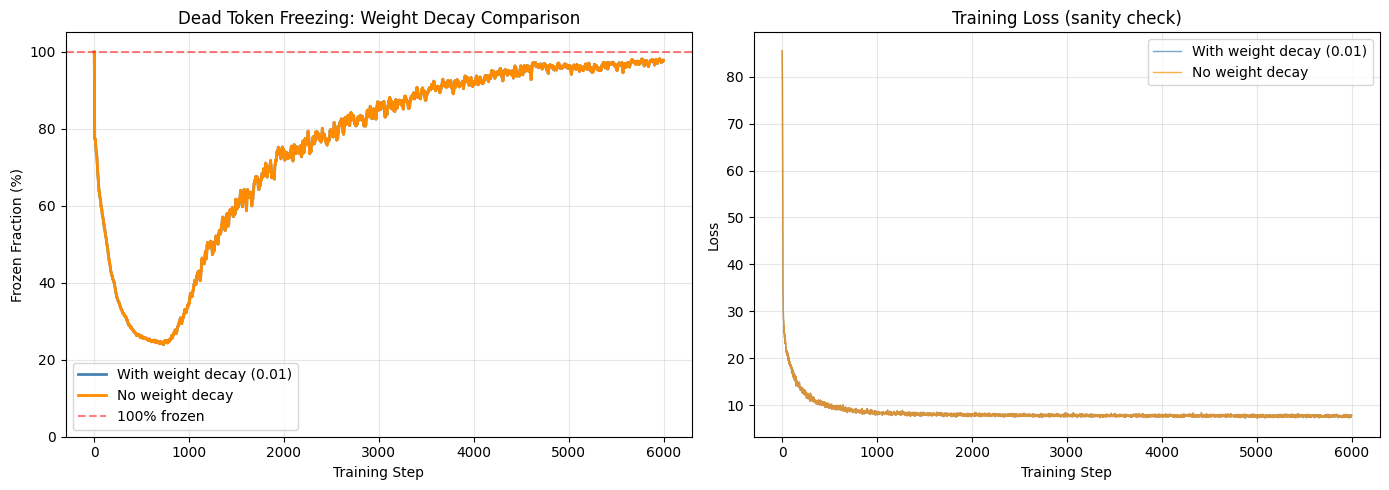

✓ Saved: weight_decay_comparison@200.png, weight_decay_comparison@72.png


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

colors = {0.01: 'steelblue', 0.0: 'darkorange'}
labels = {0.01: 'With weight decay (0.01)', 0.0: 'No weight decay'}

# Left: Frozen fraction over time
ax1 = axes[0]
for wd, history in results.items():
    ax1.plot(history['step'], [100*f for f in history['frozen_frac']], 
             label=labels[wd], color=colors[wd], linewidth=2)
ax1.axhline(100, color='red', linestyle='--', alpha=0.5, label='100% frozen')
ax1.set_xlabel('Training Step')
ax1.set_ylabel('Frozen Fraction (%)')
ax1.set_title('Dead Token Freezing: Weight Decay Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 105)

# Right: Loss curves (sanity check)
ax2 = axes[1]
for wd, history in results.items():
    ax2.plot(history['step'], history['loss'], 
             label=labels[wd], color=colors[wd], linewidth=1, alpha=0.7)
ax2.set_xlabel('Training Step')
ax2.set_ylabel('Loss')
ax2.set_title('Training Loss (sanity check)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('weight_decay_comparison@200.png', dpi=200, bbox_inches='tight', facecolor='white')
plt.savefig('weight_decay_comparison@72.png', dpi=72, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Saved: weight_decay_comparison@200.png, weight_decay_comparison@72.png")

## Summary

In [8]:
print("\n" + "="*70)
print("NUTCRACKER RESULTS")
print("="*70)

for wd, history in results.items():
    label = "With decay" if wd > 0 else "No decay"
    final = history['frozen_frac'][-1]
    max_frozen = max(history['frozen_frac'])
    print(f"\n{label} (wd={wd}):")
    print(f"  Final frozen: {100*final:.1f}%")
    print(f"  Max frozen: {100*max_frozen:.1f}%")

# Verdict
wd_final = results[0.01]['frozen_frac'][-1]
no_wd_final = results[0.0]['frozen_frac'][-1]

print("\n" + "*"*70)
if no_wd_final > 0.99 and wd_final < 0.99:
    print("★ HYPOTHESIS CONFIRMED ★")
    print("Weight decay prevents true fimbulwinter.")
    print("Without decay, dead tokens reach 100% frozen.")
elif no_wd_final > wd_final + 0.05:
    print("⚡ PARTIAL CONFIRMATION ⚡")
    print(f"No-decay freezes more ({100*no_wd_final:.1f}%) than with-decay ({100*wd_final:.1f}%).")
    print("Weight decay does impede freezing, but other factors may contribute.")
else:
    print("❓ INCONCLUSIVE ❓")
    print("Both conditions show similar freezing behavior.")
    print("Weight decay may not be the primary factor.")
print("*"*70)


NUTCRACKER RESULTS

With decay (wd=0.01):
  Final frozen: 97.8%
  Max frozen: 99.9%

No decay (wd=0.0):
  Final frozen: 97.8%
  Max frozen: 99.9%

**********************************************************************
❓ INCONCLUSIVE ❓
Both conditions show similar freezing behavior.
Weight decay may not be the primary factor.
**********************************************************************


## Export Data for Analysis

In [9]:
import pandas as pd

# Build a combined dataframe
rows = []
for wd, history in results.items():
    for i, step in enumerate(history['step']):
        rows.append({
            'weight_decay': wd,
            'step': step,
            'frozen_frac': history['frozen_frac'][i],
            'loss': history['loss'][i],
        })

df = pd.DataFrame(rows)

# Save to CSV
csv_path = 'nutcracker_results.csv'
df.to_csv(csv_path, index=False)
print(f"✓ Saved {len(df):,} rows to {csv_path}")

# Quick stats
print("\nQuick stats by weight_decay:")
print(df.groupby('weight_decay').agg({
    'frozen_frac': ['min', 'max', 'mean', 'std'],
    'loss': ['min', 'max', 'mean']
}).round(4))

✓ Saved 12,000 rows to nutcracker_results.csv

Quick stats by weight_decay:
             frozen_frac                         loss             
                     min    max    mean     std   min   max   mean
weight_decay                                                      
0.00              0.2388  0.999  0.7529  0.2362  7.25  85.5  8.554
0.01              0.2388  0.999  0.7529  0.2362  7.25  85.5  8.554


In [10]:
# Dig deeper: look at late-stage behavior
print("Late-stage frozen fraction (steps 5000-6000):")
late = df[df['step'] >= 5000]
print(late.groupby('weight_decay')['frozen_frac'].describe().round(4))

print("\n\nDifference between conditions at each step:")
pivot = df.pivot(index='step', columns='weight_decay', values='frozen_frac')
pivot['diff'] = pivot[0.0] - pivot[0.01]
print(f"Max difference: {pivot['diff'].max():.4f}")
print(f"Min difference: {pivot['diff'].min():.4f}")
print(f"Mean difference: {pivot['diff'].mean():.4f}")

# Are they EXACTLY identical?
print(f"\nExactly identical rows: {(pivot['diff'] == 0).sum()} / {len(pivot)}")

Late-stage frozen fraction (steps 5000-6000):
               count    mean     std    min     25%    50%     75%     max
weight_decay                                                              
0.00          1000.0  0.9654  0.0084  0.941  0.9592  0.966  0.9713  0.9817
0.01          1000.0  0.9654  0.0084  0.941  0.9592  0.966  0.9713  0.9817


Difference between conditions at each step:
Max difference: 0.0000
Min difference: 0.0000
Mean difference: 0.0000

Exactly identical rows: 6000 / 6000
